In [82]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io 
import scipy.optimize 

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Linear Regression (Regularized)

In [83]:
datafile = 'data/ex5data1.mat'
mat = scipy.io.loadmat( datafile )

X, y = mat['X'], mat['y']
Xval, yval = mat['Xval'], mat['yval']
Xtest, ytest = mat['Xtest'], mat['ytest']

X =     np.insert(X    ,0,1,axis=1)
Xval =  np.insert(Xval ,0,1,axis=1)
Xtest = np.insert(Xtest,0,1,axis=1)

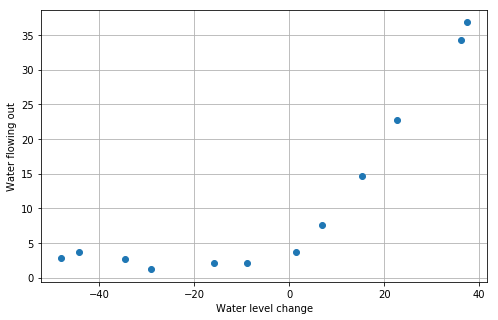

In [84]:
def plot_data():
    plt.figure(figsize=(8,5))
    plt.ylabel('Water flowing out')
    plt.xlabel('Water level change')
    plt.plot(X[:,1],y, "o")
    plt.grid(True)
    
plot_data()

#### Cost Function

In [85]:
def dot_product(theta,X): 
    return np.dot(X,theta)

def cost(mytheta,myX,myy,mylambda=0.): 
    m = myX.shape[0]
    myh = dot_product(mytheta,myX).reshape((m,1))
    mycost = float((1./(2*m)) * np.dot((myh-myy).T,(myh-myy)))
    regterm = (float(mylambda)/(2*m)) * float(mytheta[1:].T.dot(mytheta[1:]))
    return mycost + regterm

In [86]:
mytheta = np.array([[1.],[1.]])
print(cost(mytheta,X,y,mylambda=1.))

303.9931922202643


#### Gradient

In [87]:
def gradient(mytheta,myX,myy,mylambda=0.):
    mytheta = mytheta.reshape((mytheta.shape[0],1))
    m = myX.shape[0]
    myh = h(mytheta,myX).reshape((m,1))
    grad = (1./float(m))*myX.T.dot(h(mytheta,myX)-myy)
    regterm = (float(mylambda)/m)*mytheta
    regterm[0] = 0
    regterm.reshape((grad.shape[0],1))
    return grad + regterm

def gradient_flattened(mytheta,myX,myy,mylambda=0.):
    return gradient(mytheta,myX,myy,mylambda=0.).flatten()

In [88]:
mytheta = np.array([[1.],[1.]])
print(gradient(mytheta,X,y,1.))

[[-15.30301567]
 [598.25074417]]


#### Fit and Plot

In [89]:
def optimize(myTheta_initial, myX, myy, mylambda=0.,print_output=True):
    fit_theta = scipy.optimize.fmin_cg(cost,x0=myTheta_initial,\
                                       fprime=gradient_flattened,\
                                       args=(myX,myy,mylambda),\
                                       disp=print_output,\
                                       epsilon=1.49e-12,\
                                       maxiter=1000)
    fit_theta = fit_theta.reshape((myTheta_initial.shape[0],1))
    return fit_theta

In [90]:
mytheta = np.array([[1.],[1.]])
fit_theta = optimize(mytheta,X,y,0.)

Optimization terminated successfully.
         Current function value: 22.373906
         Iterations: 18
         Function evaluations: 28
         Gradient evaluations: 28


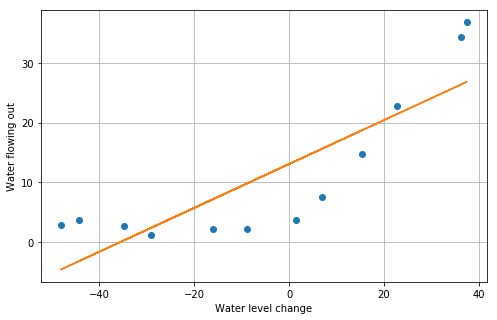

In [91]:
plot_data()
plt.plot(X[:,1],h(fit_theta,X).flatten())

### Bias-variance

#### Error Analysis

In [92]:
def plot_dataset_errors():
    initial_theta = np.array([[1.],[1.]])
    mym, error_train, error_val = [], [], []
    for x in range(1,13,1):
        train_subset = X[:x,:]
        y_subset = y[:x]
        mym.append(y_subset.shape[0])
        fit_theta = optimize(initial_theta,train_subset,y_subset,mylambda=0.,print_output=False)
        error_train.append(cost(fit_theta,train_subset,y_subset,mylambda=0.))
        error_val.append(cost(fit_theta,Xval,yval,mylambda=0.))
        
    plt.figure(figsize=(8,5))
    plt.plot(mym,error_train,label='Train')
    plt.plot(mym,error_val,label='Cross Validation')
    plt.legend()
    plt.title('Error for each dataset')
    plt.xlabel('# training examples')
    plt.ylabel('Error')
    plt.grid(True)

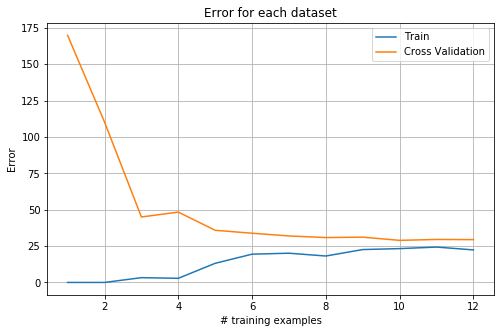

In [93]:
plot_dataset_errors()

### Polynomial Regression (Regularized)

In [94]:
def generate_polynomial_features(myX,p):
    newX = myX.copy()
    for i in range(p):
        dim = i+2
        newX = np.insert(newX,newX.shape[1],np.power(newX[:,1],dim),axis=1)
    return newX

def normalize(myX):  
    Xnorm = myX.copy()
    stored_feature_means = np.mean(Xnorm,axis=0) #column-by-column
    Xnorm[:,1:] = Xnorm[:,1:] - stored_feature_means[1:]
    stored_feature_stds = np.std(Xnorm,axis=0,ddof=1)
    Xnorm[:,1:] = Xnorm[:,1:] / stored_feature_stds[1:]
    return Xnorm, stored_feature_means, stored_feature_stds

#### Fit and Plot

In [95]:
ns = [1,2,3,4,5,6]
mylambda = 0
errors_train, errors_val = [], []
for n in ns:
    n-=1
    newXtrain = generate_polynomial_features(X,n)
    newXtrain_norm, dummy1, dummy2 = normalize(newXtrain)
    newXval = generate_polynomial_features(Xval,n)
    newXval_norm, dummy1, dummy2 = normalize(newXval)
    init_theta = np.ones((newXtrain_norm.shape[1],1))
    fit_theta = optimize(init_theta,newXtrain_norm,y,mylambda,False)
    errors_train.append(cost(fit_theta,newXtrain_norm,y))
    errors_val.append(cost(fit_theta,newXval_norm,yval))

#### Polynomial (Hyperparameter) Exploration

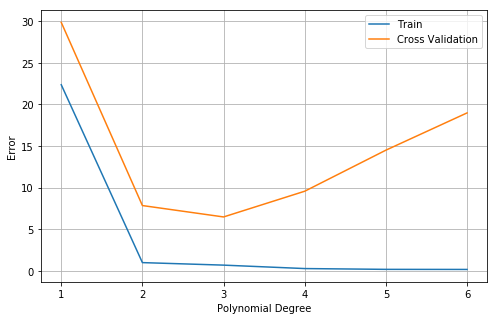

In [96]:
plt.figure(figsize=(8,5))
plt.plot(ns,errors_train,label='Train')
plt.plot(ns,errors_val,label='Cross Validation')
plt.legend()
plt.xlabel('Polynomial Degree')
plt.ylabel('Error')
plt.grid(True)

In [97]:
#Third degree appears to be the most optimal
global_d = 2 
newX = generate_polynomial_features(X,global_d)
newX_norm, stored_means, stored_stds = normalize(newX)
mytheta = np.ones((newX_norm.shape[1],1))
fit_theta = optimize(mytheta,newX_norm,y,0.)

Optimization terminated successfully.
         Current function value: 0.716365
         Iterations: 23
         Function evaluations: 43
         Gradient evaluations: 43


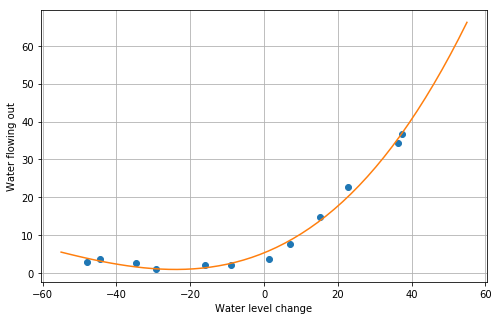

In [98]:
def plot_fit(fit_theta,means,stds):
    n_points_to_plot = 50
    xvals = np.linspace(-55,55,n_points_to_plot)
    xmat = np.ones((n_points_to_plot,1))
    
    xmat = np.insert(xmat,xmat.shape[1],xvals.T,axis=1)
    xmat = generate_polynomial_features(xmat,len(fit_theta)-2)
    #This is undoing feature normalization
    xmat[:,1:] = xmat[:,1:] - means[1:]
    xmat[:,1:] = xmat[:,1:] / stds[1:]
    plot_data()
    plt.plot(xvals,h(fit_theta,xmat))

plot_fit(fit_theta,stored_means,stored_stds)

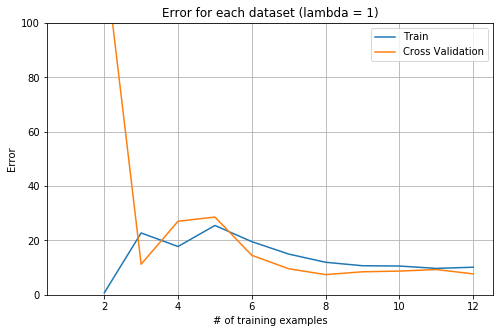

In [99]:
def plot_polynomial_error(mylambda=0.):

    initial_theta = np.ones((global_d+2,1))
    mym, error_train, error_val = [], [], []
    myXval, dummy1, dummy2 = normalize(generate_polynomial_features(Xval,global_d))

    for x in range(1,13,1):
        train_subset = X[:x,:]
        y_subset = y[:x]
        mym.append(y_subset.shape[0])
        train_subset = generate_polynomial_features(train_subset,global_d)   
        train_subset, dummy1, dummy2 = normalize(train_subset)
        fit_theta = optimize(initial_theta,train_subset,y_subset,mylambda=mylambda,print_output=False)
        error_train.append(cost(fit_theta,train_subset,y_subset,mylambda=mylambda))
        error_val.append(cost(fit_theta,myXval,yval,mylambda=mylambda))
        
    plt.figure(figsize=(8,5))
    plt.plot(mym,error_train,label='Train')
    plt.plot(mym,error_val,label='Cross Validation')
    plt.legend()
    plt.title('Error for each dataset (lambda = {})'.format(mylambda))
    plt.xlabel('# of training examples')
    plt.ylabel('Error')
    plt.ylim([0,100])
    plt.grid(True)
    
plot_polynomial_error(1)

#### Adjusting Regularization 

         Current function value: 1.571104
         Iterations: 7
         Function evaluations: 116
         Gradient evaluations: 104


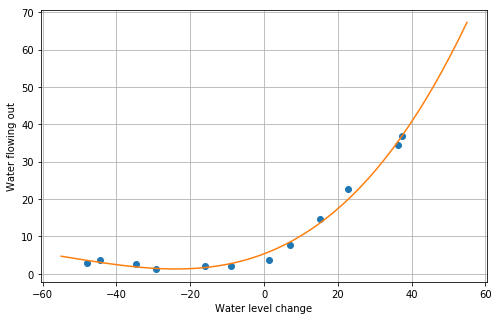

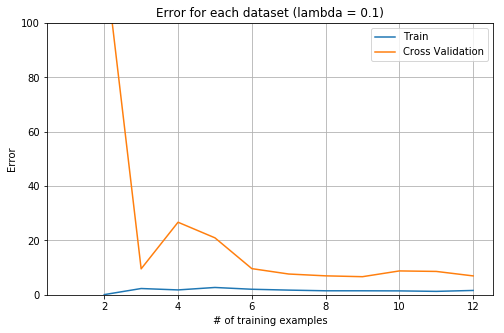

In [100]:
#Lambda = 0.1
mytheta = np.zeros((newX_norm.shape[1],1))
fit_theta = optimize(mytheta,newX_norm,y,0.1)
plot_fit(fit_theta,stored_means,stored_stds)
plot_polynomial_error(0.1)

         Current function value: 124.811522
         Iterations: 0
         Function evaluations: 44
         Gradient evaluations: 32


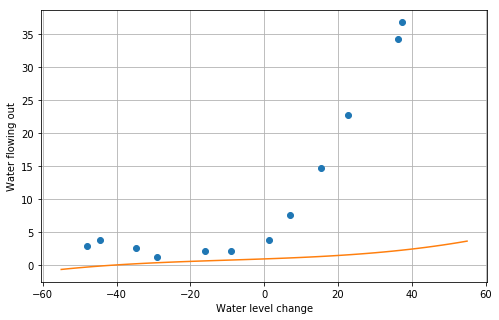

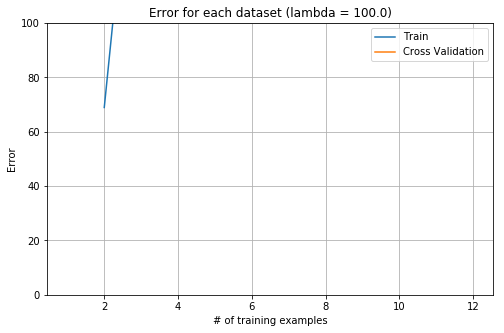

In [101]:
#Lambda = 100
mytheta = np.random.rand(newX_norm.shape[1],1)
fit_theta = optimize(mytheta,newX_norm,y,100.)
plot_fit(fit_theta,stored_means,stored_stds)
plot_polynomial_error(100.)

#### Using Cross Validation to Adjust Regularization

In [102]:
#lambdas = [0., 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1., 3., 10.]
lambdas = np.linspace(0,5,20)
errors_train, errors_val = [], []
for mylambda in lambdas:
    newXtrain = generate_polynomial_features(X,global_d)
    newXtrain_norm, dummy1, dummy2 = normalize(newXtrain)
    newXval = generate_polynomial_features(Xval,global_d)
    newXval_norm, dumamy1, dummy2 = normalize(newXval)
    init_theta = np.ones((newX_norm.shape[1],1))
    fit_theta = optimize(mytheta,newXtrain_norm,y,mylambda,False)
    errors_train.append(cost(fit_theta,newXtrain_norm,y,mylambda=mylambda))
    errors_val.append(cost(fit_theta,newXval_norm,yval,mylambda=mylambda))

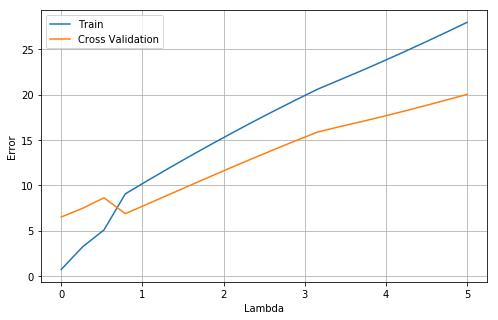

In [103]:
plt.figure(figsize=(8,5))
plt.plot(lambdas,errors_train,label='Train')
plt.plot(lambdas,errors_val,label='Cross Validation')
plt.legend()
plt.xlabel('Lambda')
plt.ylabel('Error')
plt.grid(True)